In [1]:
import os
import itertools
import time

import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
from typing import List, Tuple, Callable
from collections import defaultdict

from pathlib import Path
from PIL import Image

In [2]:
def show_image(image, path=None, title=''):
    plt.figure(figsize=(15, 15))
    plt.imshow(image)
    plt.title(title)
    if path is not None:
        plt.savefig(path)
    plt.show()
    plt.close()

def get_images(imgdir='data/') -> List[np.ndarray]:
    image_names = os.listdir(imgdir)
    images = [cv.imread(str(Path(imgdir) / i)) for i in image_names]
    return images

In [3]:
class Timer:
    def __enter__(self):
        self.start_time = time.time()
        return self

    def __exit__(self, exc_type, exc_val, exc_tb):
        self.end_time = time.time()
        self.execution_time = self.end_time - self.start_time


def apply_detector(detector, images: List[np.ndarray]) -> Tuple[List[List[cv.KeyPoint]], List[np.ndarray], float]:
    keypoints, descriptors = [], []
    mean_time = 0
    for image in images:
        with Timer() as t:
            k, d = detector.detectAndCompute(image, None)
        mean_time += t.execution_time / len(k)
        keypoints.append(k)
        descriptors.append(d)
    mean_time = mean_time / len(images)

    return keypoints, descriptors, mean_time

In [4]:
def find_repeatability(keypoints: List[List[cv.KeyPoint]], descriptors: List[np.ndarray]) -> float:
    matcher = cv.DescriptorMatcher_create(cv.DescriptorMatcher_FLANNBASED)
    presented_points = [[]] * len(keypoints)

    for query_i in range(len(keypoints)):
        for train_i in range(len(keypoints)):
            if query_i == train_i:
                continue
            matches = matcher.match(descriptors[query_i].astype(np.float32), descriptors[train_i].astype(np.float32))
            found_fraction = len(np.unique([m.trainIdx for m in matches])) / len(matches)
            presented_points[train_i].append(found_fraction)

    presented_points = np.array(presented_points)

    return presented_points.mean()


[ WARN:0@2.938] global shadow_sift.hpp:15 SIFT_create DEPRECATED: cv.xfeatures2d.SIFT_create() is deprecated due SIFT tranfer to the main repository. https://github.com/opencv/opencv/issues/16736
/var/folders/dn/p16nzwfd7tl2dy8ykjthgh000000gn/T/ipykernel_23059/4141603094.py:15: RuntimeWarning: Mean of empty slice.
  return presented_points.mean()
/opt/anaconda3/envs/cv/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


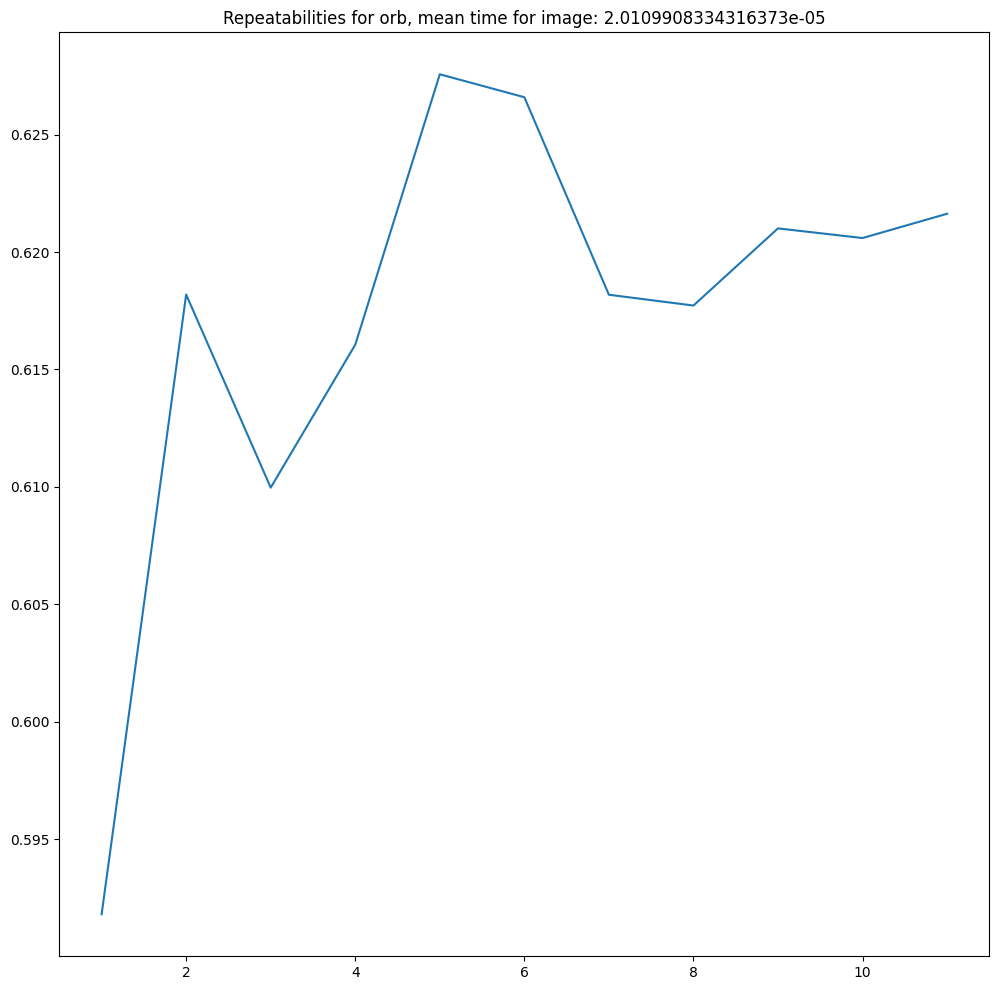

: 

: 

In [5]:
images = get_images()

detectors = {
    'orb': cv.ORB_create(),
    'sift': cv.xfeatures2d.SIFT_create(),
    'harris': cv.xfeatures2d.HarrisLaplaceFeatureDetector(),
}

for d_name in detectors:
    keypoints, descriptors, mean_time = apply_detector(detectors[d_name], images)
    repeatabilities = [find_repeatability(keypoints[:i], descriptors[:i]) for i in range(1, len(keypoints) + 1)]
    plt.figure(figsize=(12, 12))
    plt.title(f'Repeatabilities for {d_name}, mean time for image: {mean_time}')
    plt.plot(repeatabilities)
    plt.show()